## Libraries

In [2]:
# Standard library imports
from pathlib import Path

# Third-party imports
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr

## Define Paths

In [3]:
data_dir = Path.cwd().parent / 'data'
lyme_data_path = data_dir / 'UKHSA-2017-2022-Lyme-Disease.csv'
lyme_data_with_shapfile_path = data_dir / 'lyme_disease_incidence_with_shapefile.geojson'

climate_data_dir = data_dir / 'climate_data'

## Load Datasets

In [4]:
df = pd.read_csv(lyme_data_path)
df_shp = gpd.read_file(lyme_data_with_shapfile_path)

## Load the Climate Data

In [5]:
# Load the NetCDF files
nc_files = list(Path(climate_data_dir).glob('*.nc'))
if nc_files:
  climate_datasets = [xr.open_dataset(file) for file in nc_files]
  climate_data = xr.merge(climate_datasets)
else:
  raise FileNotFoundError("No GRIB or NetCDF files found in the climate_data directory")

# Extract the latitude and longitude arrays from the climate dataset
lats = climate_data.latitude.values
lons = climate_data.longitude.values

# Print available variables in the climate dataset
print("Keys (variables) in climate_data:")
print(list(climate_data.keys()))
print(climate_data)

Keys (variables) in climate_data:
['cvh', 't2m', 'e', 'tp', 'tvh']
<xarray.Dataset> Size: 12MB
Dimensions:     (longitude: 201, latitude: 240, time: 2, valid_time: 18)
Coordinates:
  * longitude   (longitude) float64 2kB -8.0 -7.9 -7.8 ... 359.7 359.8 359.9
  * latitude    (latitude) float64 2kB 49.0 49.1 49.1 49.2 ... 60.9 60.9 61.0
  * time        (time) datetime64[ns] 16B 1996-01-01 2013-11-29
  * valid_time  (valid_time) datetime64[ns] 144B 2017-05-01 ... 2022-07-01
    number      int64 8B ...
    expver      (valid_time) <U4 288B ...
Data variables:
    cvh         (time, latitude, longitude) float64 772kB nan nan ... 0.0 0.0
    t2m         (valid_time, latitude, longitude) float32 3MB nan nan ... nan
    e           (valid_time, latitude, longitude) float32 3MB nan nan ... nan
    tp          (valid_time, latitude, longitude) float32 3MB nan nan ... nan
    tvh         (time, latitude, longitude) float64 772kB nan nan ... nan nan
Attributes:
    Conventions:  CF-1.6
    history

## Find Closest Climate Data for Our Dataset

In [6]:
# Create a function to find the closest climate data point for each geographical location
def find_closest_climate_point(row: pd.DataFrame, climate_data: xr.core.dataset.Dataset, lats: list, lons: list) -> pd.Series:
  """
  Find the closest climate data point for a given latitude and longitude.
  """
  # Calculate distance to all climate grid points
  lat_idx = np.abs(lats - row['LAT']).argmin()
  lon_idx = np.abs(lons - row['LONG']).argmin()

  # Get the temperature and precipitation for this point
  # Taking the mean across all time periods
  temp = float(climate_data['t2m'].sel(latitude=lats[lat_idx], longitude=lons[lon_idx]).mean().values) - 273.15  # Convert to Celsius
  precip = float(climate_data['tp'].sel(latitude=lats[lat_idx], longitude=lons[lon_idx]).mean().values) * 1000  # Convert to mm
  evaporation = float(climate_data['e'].sel(latitude=lats[lat_idx], longitude=lons[lon_idx]).mean().values) * 1000  # Convert to mm
  veg_cover = float(climate_data['cvh'].sel(latitude=lats[lat_idx], longitude=lons[lon_idx]).mean().values)  # High vegetation cover
  veg_type = float(climate_data['tvh'].sel(latitude=lats[lat_idx], longitude=lons[lon_idx]).mean().values)  # Type of high vegetation
  
  return pd.Series({
    'temperature': temp,
    'precipitation': precip,
    'evaporation': evaporation,
    'high_vegetation_cover': veg_cover,
    'type_of_high_vegetation': veg_type
  })

In [7]:
climate_cols = ['temperature', 'precipitation', 'evaporation', 'high_vegetation_cover', 'type_of_high_vegetation']

# Create a copy of the merged dataframe to avoid modifying the original
final_df = df_shp.copy()

# Apply the function to each row in the dataframe
# Only process rows that have valid coordinates
mask = (~final_df['LONG'].isna()) & (~final_df['LAT'].isna())
climate_vars = final_df[mask].apply(
  lambda row: find_closest_climate_point(row, climate_data, lats, lons),
  axis=1
)

# Join climate data back to the main dataframe
final_df.loc[
  mask, 
  climate_cols,
] = climate_vars

# Display summary of the new dataframe
print(f"Added climate data to {mask.sum()} out of {len(final_df)} rows")
print("\nSample of final dataframe with climate data:")
final_df.head()

Added climate data to 622 out of 622 rows

Sample of final dataframe with climate data:


,UTLA22CD,UTLA22NM,UTLA22NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,Year,Council,...,Population,Incidence,Lower_95CI,Upper_95CI,geometry,temperature,precipitation,evaporation,high_vegetation_cover,type_of_high_vegetation
0,E06000001,Hartlepool,None,447160,531474,-1.27018,54.6761,4b2f43f2-3cb7-46e3-9b77-6f6866ead5a0,2017.0,Hartlepool,...,93019.0,1.07505,0.02722,5.98979,"MULTIPOLYGON (((450154.599 525938.201, 450140....",13.930505,2.241989,-2.600945,NaN,NaN
1,E06000001,Hartlepool,None,447160,531474,-1.27018,54.6761,4b2f43f2-3cb7-46e3-9b77-6f6866ead5a0,2018.0,Hartlepool,...,93242.0,0.00000,0.00000,3.95624,"MULTIPOLYGON (((450154.599 525938.201, 450140....",13.930505,2.241989,-2.600945,NaN,NaN
2,E06000001,Hartlepool,None,447160,531474,-1.27018,54.6761,4b2f43f2-3cb7-46e3-9b77-6f6866ead5a0,2019.0,Hartlepool,...,92401.0,0.00000,0.00000,3.99225,"MULTIPOLYGON (((450154.599 525938.201, 450140....",13.930505,2.241989,-2.600945,NaN,NaN
3,E06000001,Hartlepool,None,447160,531474,-1.27018,54.6761,4b2f43f2-3cb7-46e3-9b77-6f6866ead5a0,2020.0,Hartlepool,...,92202.0,0.00000,0.00000,4.00087,"MULTIPOLYGON (((450154.599 525938.201, 450140....",13.930505,2.241989,-2.600945,NaN,NaN
4,E06000001,Hartlepool,None,447160,531474,-1.27018,54.6761,4b2f43f2-3cb7-46e3-9b77-6f6866ead5a0,2021.0,Hartlepool,...,92575.0,0.00000,0.00000,3.98475,"MULTIPOLYGON (((450154.599 525938.201, 450140....",13.930505,2.241989,-2.600945,NaN,NaN


In [8]:
print("\nMissing values in climate columns:")
print(final_df[climate_cols].isna().sum())

final_df[climate_cols] = final_df[climate_cols].fillna(0.0)
vegetation_cols = ['high_vegetation_cover', 'type_of_high_vegetation']
climate_cols = ['temperature', 'precipitation', 'evaporation']

# final_df[vegetation_cols] = final_df[vegetation_cols].fillna(0.0, inplace=True)
# final_df[climate_cols].apply(lambda col: col.fillna(col.mean()), axis=0)


Missing values in climate columns:
temperature                356
precipitation              356
evaporation                356
high_vegetation_cover      596
type_of_high_vegetation    596
dtype: int64


## Visualise Incidence Rate and Climate Data

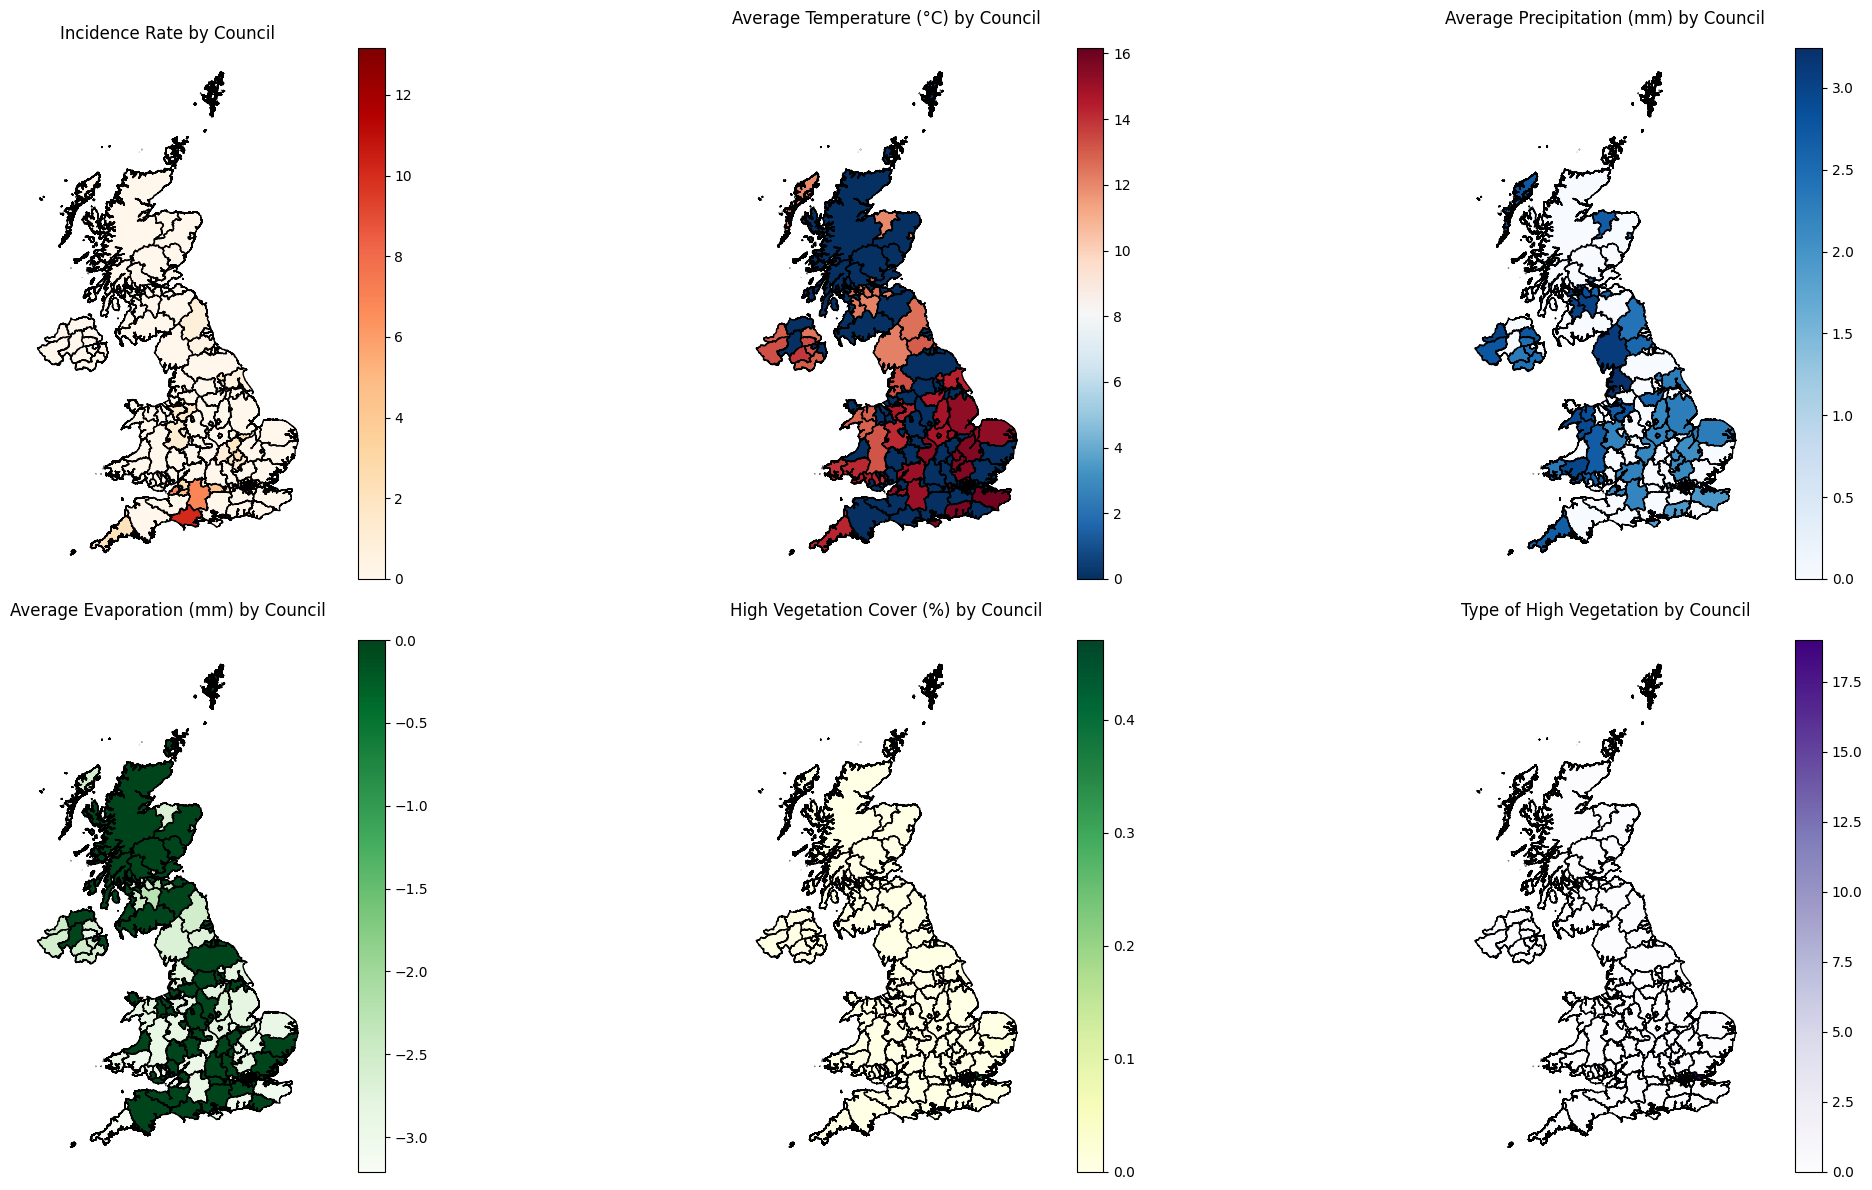

In [24]:
# Select rows where Year is 2017 or missing (NaN)
df_2017 = final_df[(final_df['Year'] == 2017) | (final_df['Year'].isna())]
fig, axs = plt.subplots(2, 3, figsize=(24, 12))

fig.suptitle('Lyme Disease Incidence and Climate Variables - 2017', fontsize=20)


# Plot incidence rate
df_2017.plot(column='Incidence', ax=axs[0, 0], legend=True, cmap='OrRd', edgecolor='black')
axs[0, 0].set_title('Incidence Rate by Council')
axs[0, 0].axis('off')

# Plot temperature data
df_2017.plot(column='temperature', ax=axs[0, 1], legend=True, cmap='RdBu_r', edgecolor='black')
axs[0, 1].set_title('Average Temperature (°C) by Council')
axs[0, 1].axis('off')

# Plot precipitation data
df_2017.plot(column='precipitation', ax=axs[0, 2], legend=True, cmap='Blues', edgecolor='black')
axs[0, 2].set_title('Average Precipitation (mm) by Council')
axs[0, 2].axis('off')

# Plot evaporation data
df_2017.plot(column='evaporation', ax=axs[1, 0], legend=True, cmap='Greens', edgecolor='black')
axs[1, 0].set_title('Average Evaporation (mm) by Council')
axs[1, 0].axis('off')

# Plot high vegetation cover
df_2017.plot(column='high_vegetation_cover', ax=axs[1, 1], legend=True, cmap='YlGn', edgecolor='black')
axs[1, 1].set_title('High Vegetation Cover (%) by Council')
axs[1, 1].axis('off')

# Plot type of high vegetation
df_2017.plot(column='type_of_high_vegetation', ax=axs[1, 2], legend=True, cmap='Purples', edgecolor='black')
axs[1, 2].set_title('Type of High Vegetation by Council')
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Select rows where Year is 2021 or missing (NaN)
df_2021 = final_df[(final_df['Year'] == 2021) | (final_df['Year'].isna())]
fig, axs = plt.subplots(2, 3, figsize=(24, 12))

fig.suptitle('Lyme Disease Incidence and Climate Variables - 2021', fontsize=20)

# Plot incidence rate
df_2021.plot(column='Incidence', ax=axs[0, 0], legend=True, cmap='OrRd', edgecolor='black')
axs[0, 0].set_title('Incidence Rate by Council')
axs[0, 0].axis('off')

# Plot temperature data
df_2021.plot(column='temperature', ax=axs[0, 1], legend=True, cmap='RdBu_r', edgecolor='black')
axs[0, 1].set_title('Average Temperature (°C) by Council')
axs[0, 1].axis('off')

# Plot precipitation data
df_2021.plot(column='precipitation', ax=axs[0, 2], legend=True, cmap='Blues', edgecolor='black')
axs[0, 2].set_title('Average Precipitation (mm) by Council')
axs[0, 2].axis('off')

# Plot evaporation data
df_2021.plot(column='evaporation', ax=axs[1, 0], legend=True, cmap='Greens', edgecolor='black')
axs[1, 0].set_title('Average Evaporation (mm) by Council')
axs[1, 0].axis('off')

# Plot high vegetation cover
df_2021.plot(column='high_vegetation_cover', ax=axs[1, 1], legend=True, cmap='YlGn', edgecolor='black')
axs[1, 1].set_title('High Vegetation Cover (%) by Council')
axs[1, 1].axis('off')

# Plot type of high vegetation
df_2021.plot(column='type_of_high_vegetation', ax=axs[1, 2], legend=True, cmap='Purples', edgecolor='black')
axs[1, 2].set_title('Type of High Vegetation by Council')
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

## Store Final Dataset

In [23]:
final_df.to_csv(data_dir / 'final_dataset.csv')